# Walkthrough of `secdetect`
---

<img src="https://raw.githubusercontent.com/lanery/secdetect/v0.2.x/docs/example.png" width="700" />

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import hed_from_rgb
 
# Where the magic happens ─┐
import secdetect  # <──────┘

In [56]:
from matplotlib.patches import Rectangle
plt.set_cmap('magma');
%matplotlib inline

## Adjustments
---
`secdetect.adjust`

#### Contrast enhancement - `secdetect.enhance_contrast`

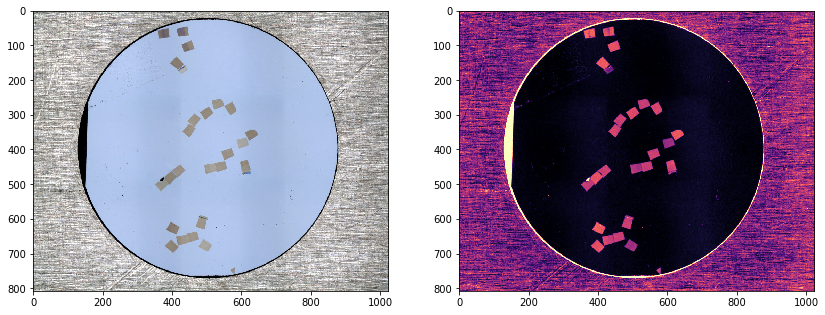

In [57]:
# Load an overview image
imin = secdetect.data.load(12)

# Enhance contrast
enhanced = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))
ax1.imshow(imin);
ax2.imshow(enhanced);

## Background subtraction
---
`secdetect.ringdetect`

#### Finding the outer ring using Canny edge detection

In [58]:
# Import canny edge detector
from skimage.feature import canny

# Set parameters for edge detection
canny_kws = {
    'sigma': 4,
    'low_threshold': 0.10,
    'high_threshold': 0.99,
    'use_quantiles': True,
}

# Perform edge detection
edges = canny(enhanced, **canny_kws)

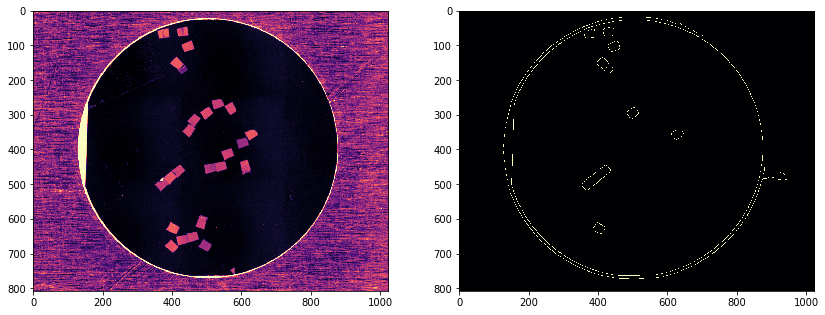

In [59]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))
ax1.imshow(enhanced);
ax2.imshow(edges);

#### Cropping and masking

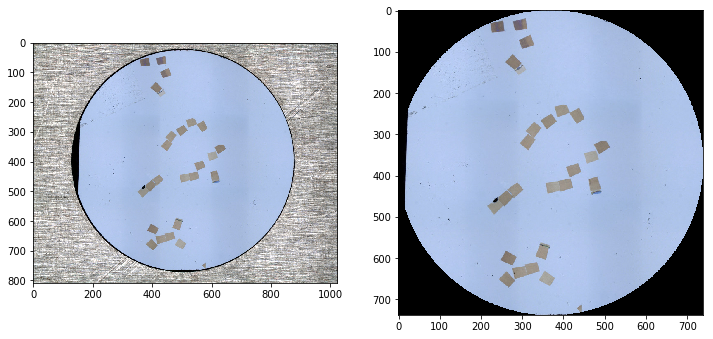

In [60]:
# Detect circle and extract coordinates and radius
cx, cy, r = secdetect.find_ring(edges)

# Crop to outer ring and subtract metal background
cropped = secdetect.crop_to_ring(imin.copy(), cx=cx, cy=cy, radius=r)

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imin);
ax2.imshow(cropped);

## Section detection
---
`secdetect.detection`

#### Felzenswalb segmentation

In [61]:
# Import felzenswalb segmentation
from skimage.segmentation import felzenszwalb

# Set parameters for felzenswalb segmentation
felzenswalb_kws = {
    'scale': 750,
    'sigma': 1.0,
    'min_size': 500,
    'multichannel': imin.ndim>2
}

# Perform felzenswalb segmentation
imfz = felzenszwalb(cropped, **felzenswalb_kws)

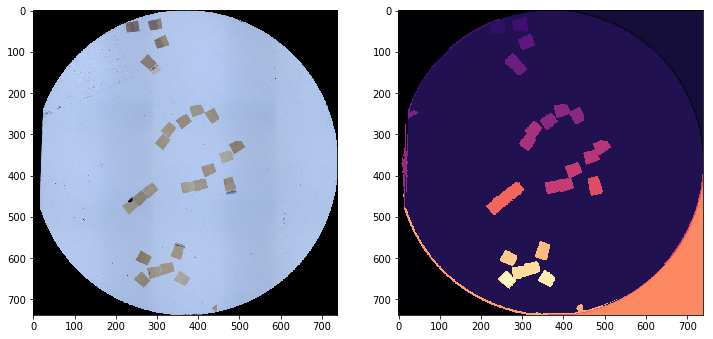

In [62]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(cropped);
ax2.imshow(imfz);

#### Clearing the border

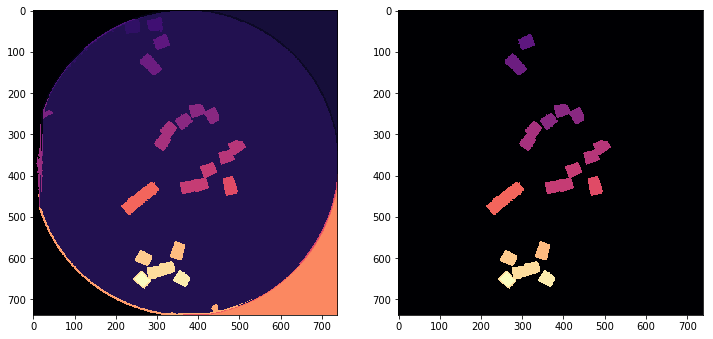

In [63]:
# Import clear_border
from skimage.segmentation import clear_border

# Set parameters for border clearing
clear_border_kws = {
    'buffer_size': 50
}

# Perform border clearing
cleaned = clear_border(imfz, **clear_border_kws)

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imfz);
ax2.imshow(cleaned);

#### Label segments

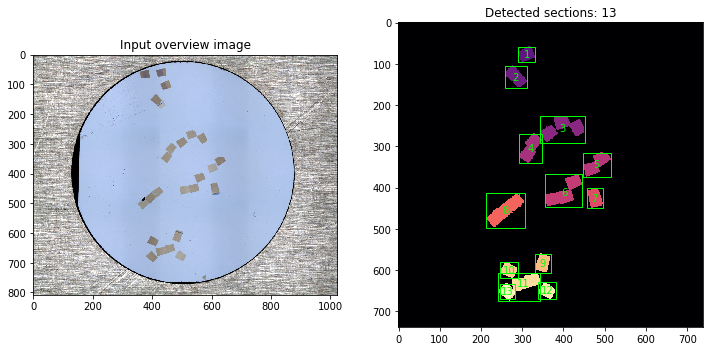

In [66]:
# Import labelling
from skimage.measure import regionprops

# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(imin);
ax2.imshow(cleaned);

# Show section bounding boxes
for i, region in enumerate(regionprops(cleaned)):
    y0, x0, y1, x1 = region.bbox
    r = Rectangle((x0, y0), x1-x0, y1-y0, fill=False,
                  edgecolor='#00FF00', lw=1)
    ax2.add_patch(r)
    ax2.text(x=region.centroid[1], y=region.centroid[0], s=i+1,
             color='#00FF00', ha='center', va='center')
    
# Figure aesthetics
N = len(regionprops(cleaned))
ax1.set_title('Input overview image');
ax2.set_title(f'Detected sections: {N}');